# Connect to database

In [3]:
from query_database import QueryDatabase

df = QueryDatabase("SELECT * FROM supplier_invoice.invoice_202407;").df
df.head()

,Förvaltning,Leverantör,Organisationsnummer,Verifikationsnummer,Konto,Kontotext,Belopp exkl moms
0,163 - Socialnämnden Nordost,NICOLE AJAKAYE,None,1631114400,7499,Övriga främmande tjänster,"35 000,00"
1,163 - Socialnämnden Nordost,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,1631112249,7499,Övriga främmande tjänster,"1 740,00"
2,300 - Stadsbyggnadsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,3001072870,7499,Övriga främmande tjänster,"1 000,00"
3,300 - Stadsbyggnadsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,3001072852,7499,Övriga främmande tjänster,"7 000,00"
4,560 - Kretslopp och vattennämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601374600,7231,Reklam och information,"1 740,00"


In [4]:
df.shape

(114364, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114364 entries, 0 to 114363
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Förvaltning          114364 non-null  object
 1   Leverantör           114364 non-null  object
 2   Organisationsnummer  114189 non-null  object
 3   Verifikationsnummer  114364 non-null  int64 
 4   Konto                114364 non-null  int64 
 5   Kontotext            114364 non-null  object
 6   Belopp exkl moms     114364 non-null  object
dtypes: int64(2), object(5)
memory usage: 6.1+ MB


In [6]:
df["Belopp exkl moms"]

0         35 000,00
1          1 740,00
2          1 000,00
3          7 000,00
4          1 740,00
            ...    
114359     7 435,12
114360       -69,84
114361      -446,11
114362     1 164,03
114363    18 515,99
Name: Belopp exkl moms, Length: 114364, dtype: object

In [10]:
df.loc[:, "Belopp exkl moms"] = df["Belopp exkl moms"].str[:-3].str.replace(" ", "").astype(int)
df.head()

,Förvaltning,Leverantör,Organisationsnummer,Verifikationsnummer,Konto,Kontotext,Belopp exkl moms
0,163 - Socialnämnden Nordost,NICOLE AJAKAYE,None,1631114400,7499,Övriga främmande tjänster,35000
1,163 - Socialnämnden Nordost,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,1631112249,7499,Övriga främmande tjänster,1740
2,300 - Stadsbyggnadsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,3001072870,7499,Övriga främmande tjänster,1000
3,300 - Stadsbyggnadsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,3001072852,7499,Övriga främmande tjänster,7000
4,560 - Kretslopp och vattennämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601374600,7231,Reklam och information,1740


In [11]:
from database import Database
from constants import DATABASE_PATH

with Database(DATABASE_PATH) as db:
    # can use df inside of duckdb
    db.connection.register('df', df)
    db.query("CREATE SCHEMA IF NOT EXISTS refined_layer;")

    db.query("""
    CREATE TABLE IF NOT EXISTS refined_layer.invoice_202407
             AS SELECT * FROM df;
    """)

In [12]:
QueryDatabase("SELECT * FROM refined_layer.invoice_202407;").df

,Förvaltning,Leverantör,Organisationsnummer,Verifikationsnummer,Konto,Kontotext,Belopp exkl moms
0,163 - Socialnämnden Nordost,NICOLE AJAKAYE,None,1631114400,7499,Övriga främmande tjänster,35000
1,163 - Socialnämnden Nordost,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,1631112249,7499,Övriga främmande tjänster,1740
2,300 - Stadsbyggnadsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,3001072870,7499,Övriga främmande tjänster,1000
3,300 - Stadsbyggnadsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,3001072852,7499,Övriga främmande tjänster,7000
4,560 - Kretslopp och vattennämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601374600,7231,Reklam och information,1740
...,...,...,...,...,...,...,...
114359,690 - Kulturnämnden,THE BOOK SERVICE LTD,SAKNAS,6901233156,1411,Förråd och lager,7435
114360,690 - Kulturnämnden,THE BOOK SERVICE LTD,SAKNAS,6901233156,2663,"Beräknad utgående moms import, 6%",-69
114361,690 - Kulturnämnden,THE BOOK SERVICE LTD,SAKNAS,6901233156,2663,"Beräknad utgående moms import, 6%",-446
114362,690 - Kulturnämnden,THE BOOK SERVICE LTD,SAKNAS,6901233156,6851,Porto och postavgifter,1164


In [16]:
df_total_cost = QueryDatabase(
    """
    SELECT 
        leverantör,
        SUM("Belopp exkl moms") AS "Summa (kr)"
    FROM 
        refined_layer.invoice_202407
    GROUP BY 
        leverantör
    ORDER BY
        "Summa (kr)"
    DESC;
    """
).df

df_total_cost.head()

,Leverantör,Summa (kr)
0,GÖTEBORGS STADS LEASING AB,59669283.0
1,KPA PENSIONSSERVICE AB,59613143.0
2,RÄDDNINGSTJÄNSTEN STORGÖTEBORG,47423558.0
3,GRYAAB AB,45326256.0
4,RENOVA,33453507.0


<Axes: title={'center': 'Total kostnad'}, ylabel='Leverantör'>

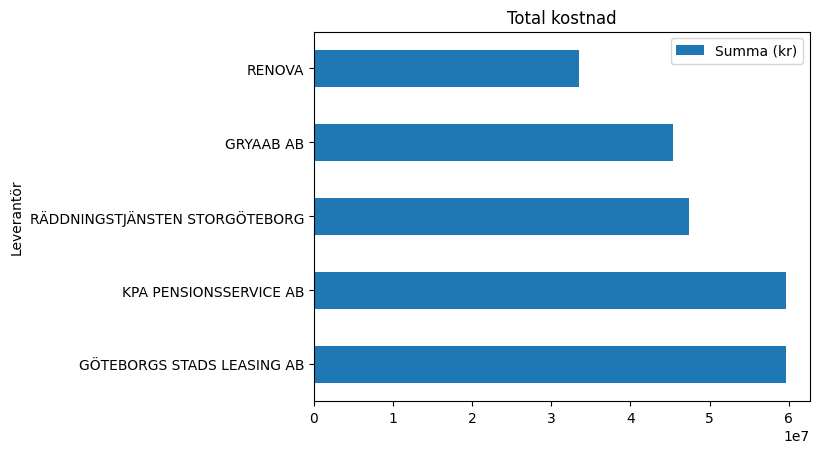

In [19]:
df_total_cost.head().plot(kind = "barh", x="Leverantör", y="Summa (kr)", title = "Total kostnad")